# 1. Project Overview

### Introduction
This project aims to develop a sophisticated machine learning model to accurately detect and classify various types of electrical faults in transmission lines. By leveraging advanced algorithms and comprehensive data analysis, the goal is to enhance the efficiency of power distribution and significantly reduce risks associated with electrical faults, such as power outages and wildfires.

### Background
Electrical faults in transmission lines are a critical concern in power systems, impacting the stability and reliability of electricity distribution. The rapid identification and classification of these faults are essential for timely intervention and prevention of larger systemic failures.

### About DataSet
We have modeled a power system in MATLAB to simulate fault analysis. The power system consists of 4 generators of 11 × 10^3 V, each pair located at each end of the transmission line. Transformers are present in between to simulate and study the various faults at the midpoint of the transmission line.
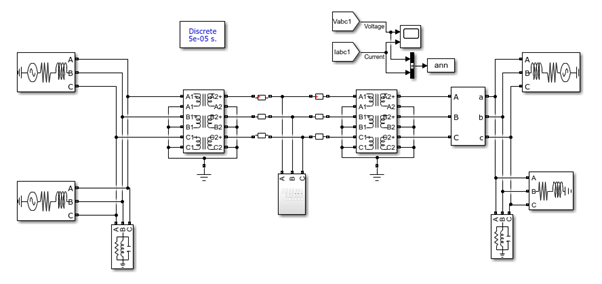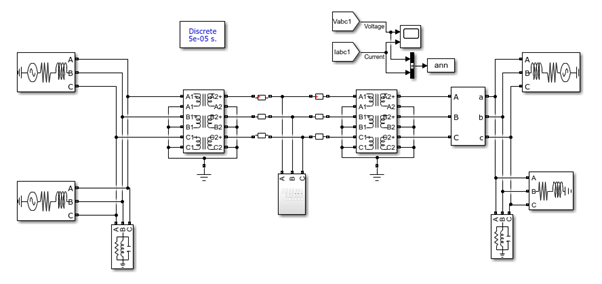

We simulate the circuit under normal conditions as well as under various fault conditions. We then collect and save the measured Line Voltages and Line Currents at the output side of the power system. We collected nearly 12000 data points, and then the data is labeled.


# 2. Data Understanding and Preparation
In this section, we delve into the dataset at hand, understanding its characteristics and preparing it for subsequent analysis and model development.

## 2.1 Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from scipy.stats import uniform, randint
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as IMBPipeline
import tensorflow as tf
from tensorflow import keras

#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import cross_validate
#from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import classification_report, confusion_matrix
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder
#from sklearn.model_selection import cross_validate, StratifiedKFold
#from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import classification_report
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import StratifiedKFold
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import LabelEncoder
#from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
#import matplotlib.pyplot as plt
#from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
import warnings

# Filter out all warnings
warnings.filterwarnings("ignore")

In [3]:

# Load the dataset
file_path = '/kaggle/input/electrical-fault-detection-and-classification/classData.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("First few rows of the dataset:")
data.head()

First few rows of the dataset:


,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983


The dataset, classData.csv, comprises measurements from a simulated power system. It includes data points for line voltages and line currents under various operational and fault conditions. The key features and their descriptions are as follows:

* Current in Line A (Ia)
* Current in Line B (Ib)
* Current in Line C (Ic)
* Voltage in Line A (Va)
* Voltage in Line B (Vb)
* Voltage in Line C (Vc)

The dataset also includes labels indicating different types of faults in a binary format, corresponding to various fault conditions in the transmission line.

## 2.2 Checking Data Quality

In [4]:
# Checking for missing values
print("\nChecking for missing values:")
missing_values = data.isnull().sum()

# Checking for any duplicates
duplicate_rows = data.duplicated().sum()

missing_values,duplicate_rows


Checking for missing values:


(G     0
 C     0
 B     0
 A     0
 Ia    0
 Ib    0
 Ic    0
 Va    0
 Vb    0
 Vc    0
 dtype: int64,
 0)

* **Missing Values:** There are no missing values in the dataset.
* **Duplicate Rows:** There are no duplicate rows in the dataset.

## 2.3 Defining electrical faults categories 
Here, dependent variable is different types of electrical faults. Combining data from columns 'G', 'C', 'B' and 'A', we define following classes of possible states of electrical transmission lines.

1. '0000': 'No Fault',
2. '1000': 'Single Line to Ground A',
3. '0100': 'Single Line to Ground B',
4. '0010': 'Single Line to Ground C',
5. '0011': 'Line-to-Line BC',
6. '0101': 'Line-to-Line AC',
7. '1001': 'Line-to-Line AB',
8. '1010': 'Line-to-Line with Ground AB',
9. '0101': 'Line-to-Line with Ground AC',
10. '0110': 'Line-to-Line with Ground BC',
11. '0111': 'Three-Phase',
12. '1111': 'Three-Phase with Ground',
13. '1011': 'Line A Line B to Ground Fault'

In [5]:
# Converting the fault indicator columns to a single label representing the type of fault
data['Fault_Type'] = data[['G', 'C', 'B', 'A']].astype(str).agg(''.join, axis=1)

# Defining the fault types
fault_types = {
    '0000': 'No Fault',
    '1000': 'Single Line to Ground A',
    '0100': 'Single Line to Ground B',
    '0010': 'Single Line to Ground C',
    '0011': 'Line-to-Line BC',
    '0101': 'Line-to-Line AC',
    '1001': 'Line-to-Line AB',
    '1010': 'Line-to-Line with Ground AB',
    '0101': 'Line-to-Line with Ground AC',
    '0110': 'Line-to-Line with Ground BC',
    '0111': 'Three-Phase',
    '1111': 'Three-Phase with Ground',
    '1011': 'Line A Line B to Ground Fault'
}

# Mapping fault type codes to fault type names
data['Fault_Type'] = data['Fault_Type'].map(fault_types)

# Counting the occurrences of each fault type
fault_type_counts = data['Fault_Type'].value_counts()
fault_type_counts


Fault_Type
No Fault                         2365
Line A Line B to Ground Fault    1134
Three-Phase with Ground          1133
Line-to-Line AB                  1129
Three-Phase                      1096
Line-to-Line with Ground BC      1004
Name: count, dtype: int64

We have successfully transformed the output columns ('G', 'C', 'B', 'A') into a single label representing the type of fault. Here are the counts of each fault type in your dataset:

* **No Fault**: 2365 occurrences
* **Line A Line B to Ground Fault**: 1134 occurrences
* **Three-Phase with Ground**: 1133 occurrences
* **Line-to-Line AB**: 1129 occurrences
* **Three-Phase**: 1096 occurrences
* **Line-to-Line with Ground BC**: 1004 occurrences

In our dataset, we don't have occurances of the other types of faults. Hence, we will focus on building ML model which would predict if the transmission is in above 6 defined states.

# 3. Exploratory Data Analysis

## 3.1 Descriptive Statistics

In [6]:
# Descriptive statistics
print("\nDescriptive Statistics:")
data.describe()



Descriptive Statistics:


,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
count,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000
mean,0.432006,0.411271,0.555527,0.571429,13.721194,-44.845268,34.392394,-0.007667,0.001152,0.006515
std,0.495387,0.492095,0.496939,0.494903,464.741671,439.269195,371.107412,0.289150,0.313437,0.307897
min,0.000000,0.000000,0.000000,0.000000,-883.542316,-900.526951,-883.357762,-0.620748,-0.608016,-0.612709
25%,0.000000,0.000000,0.000000,0.000000,-119.802518,-271.845947,-61.034219,-0.130287,-0.159507,-0.215977
50%,0.000000,0.000000,1.000000,1.000000,2.042805,5.513317,-4.326711,-0.005290,0.001620,0.009281
75%,1.000000,1.000000,1.000000,1.000000,227.246377,91.194282,49.115141,0.111627,0.153507,0.239973
max,1.000000,1.000000,1.000000,1.000000,885.738571,889.868884,901.274261,0.595342,0.627875,0.600179


 **Fault Indicators (G, C, B, A):** 
 * These are binary (0 or 1), with the means indicating the proportion of each fault type in the dataset.

**Currents (Ia, Ib, Ic):**
* The mean values are near zero, but the standard deviations are large, indicating wide variability.
* The minimum and maximum values suggest the presence of extreme values or outliers.

**Voltages (Va, Vb, Vc):**

* The mean values are close to zero, with relatively small standard deviations.
* The voltage readings also have a wide range, as indicated by their min and max values.

**Observations and Domain Insights**
* **Outliers:** The large standard deviations in the current readings (Ia, Ib, Ic) suggest the presence of outliers. This is typical in electrical fault data, as faults can cause significant deviations in current.
* **Binary Fault Indicators:** The mean values of the fault indicators suggest a somewhat balanced representation of different fault types.
* **Voltage Stability:** Voltage readings appear to be more stable than current readings, which is common as voltage changes are usually less dramatic than current changes in fault conditions.

## 3.2 Data Distribution

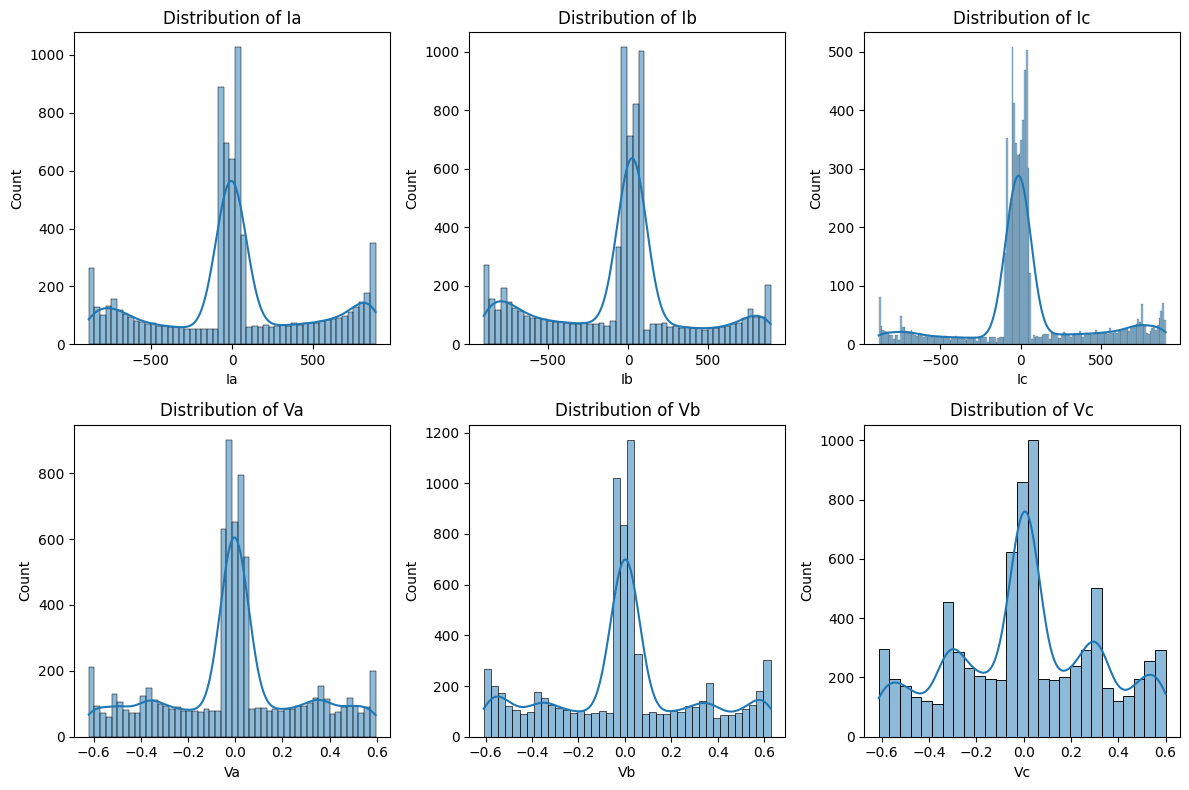

In [7]:
# Data Visualization: Histograms for each feature
features = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

* Current readings have wide and varied distributions, reflecting the impact of different fault conditions.
* Voltage readings show more concentrated distributions around zero, indicating less variation compared to current readings.

## 3.3 Correlation matrix


Correlation Matrix:
          Ia        Ib        Ic        Va        Vb        Vc
Ia  1.000000 -0.374241 -0.276457  0.035682 -0.274612  0.246043
Ib -0.374241  1.000000 -0.528291  0.029118  0.032101 -0.060023
Ic -0.276457 -0.528291  1.000000 -0.069137 -0.056967  0.122919
Va  0.035682  0.029118 -0.069137  1.000000 -0.480247 -0.450225
Vb -0.274612  0.032101 -0.056967 -0.480247  1.000000 -0.566986
Vc  0.246043 -0.060023  0.122919 -0.450225 -0.566986  1.000000


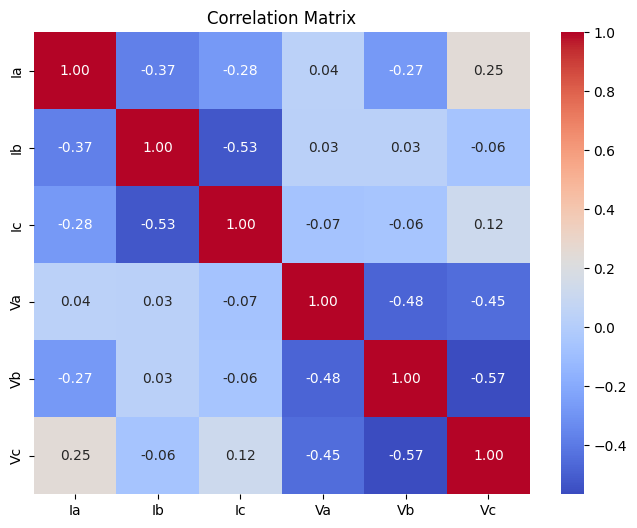

In [8]:
# Correlation matrix
print("\nCorrelation Matrix:")
correlation_matrix = data[features].corr()
print(correlation_matrix)

# Heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


Here’s a breakdown of some key correlations in your matrix:

1. **Ia and Ib:** Correlation coefficient is -0.374241, indicating a moderate negative correlation. As the current in line A (Ia) increases, the current in line B (Ib) tends to decrease, and vice versa.

2. **Ib and Ic:** Correlation coefficient is -0.528291, showing a stronger negative correlation than between Ia and Ib. This suggests that as Ib increases, Ic decreases more consistently.

3. **Va, Vb, and Vc:** These voltages show negative correlations with each other (e.g., Va and Vb have a correlation of -0.480247). This might be due to the nature of the electrical system where a rise in voltage in one line could be associated with a drop in another.

4. **Ia and Vc:** With a correlation coefficient of 0.246043, there is a weak positive correlation, suggesting that when the current in line A increases, the voltage in line C tends to slightly increase as well.

5. **Ic and Vc:** The correlation of 0.122919 is weak, indicating a slight positive relationship between the current in line C and the voltage in line C.

Overall, these correlations can give insights into how current and voltage variables interact in your electrical system, which is crucial for understanding and predicting faults.

## 3.4 Visualization of Fault Types
The distribution of fault types in the dataset is visualized through a count plot. This shows the frequency of each fault type, providing insights into the most common and rare fault scenarios in the dataset.

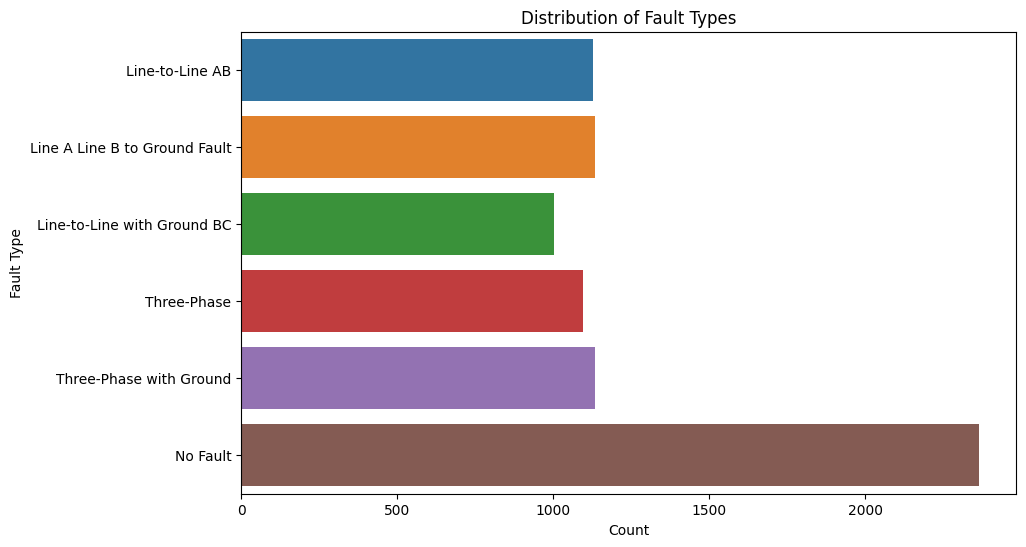

In [9]:
# Plotting the distribution of fault types
plt.figure(figsize=(10, 6))
sns.countplot(y=data['Fault_Type'])
plt.title('Distribution of Fault Types')
plt.xlabel('Count')
plt.ylabel('Fault Type')
plt.show()

## 3.5 Feature Distributions by Fault Type
Boxplots for each feature (current and voltage readings) segmented by fault type reveal significant variations in these readings across different fault conditions. This variation is crucial for the model to learn and differentiate between fault types.

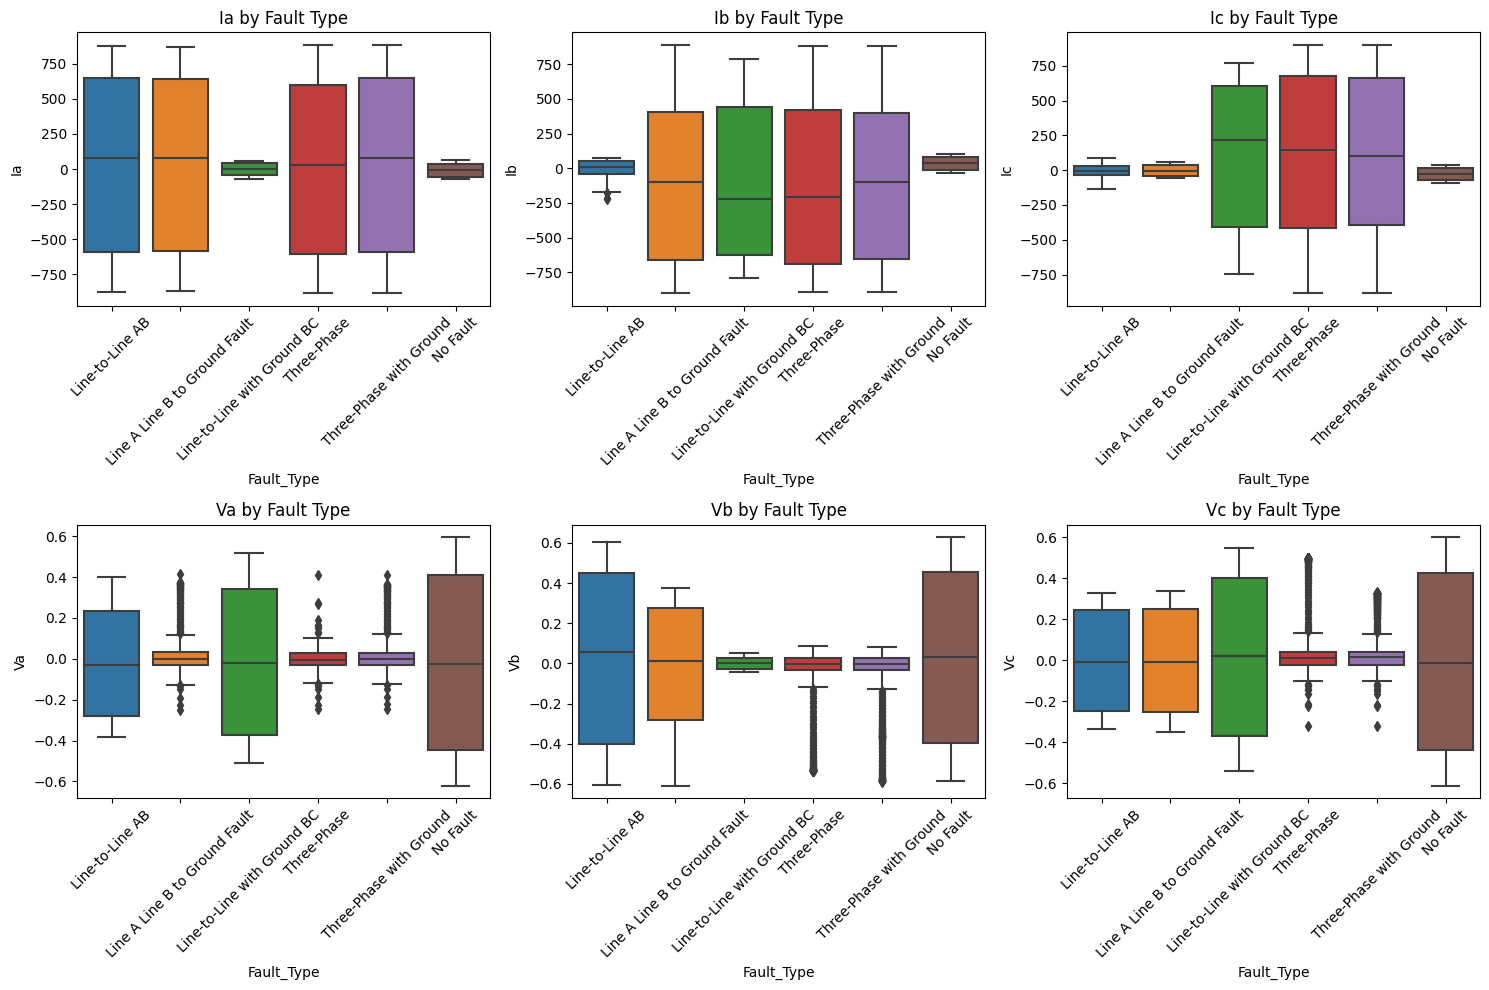

In [10]:
# Boxplots for each feature by fault type
features = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Fault_Type', y=feature, data=data)
    plt.xticks(rotation=45)
    plt.title(f'{feature} by Fault Type')
plt.tight_layout()
plt.show()

## 3.6 Pairwise Relationships of Features
The pairplot illustrates the pairwise relationships and distributions of the features. This visualization helps in understanding how different current and voltage readings relate to each other and can highlight potential linear or non-linear relationships, as well as anomalies or outliers.

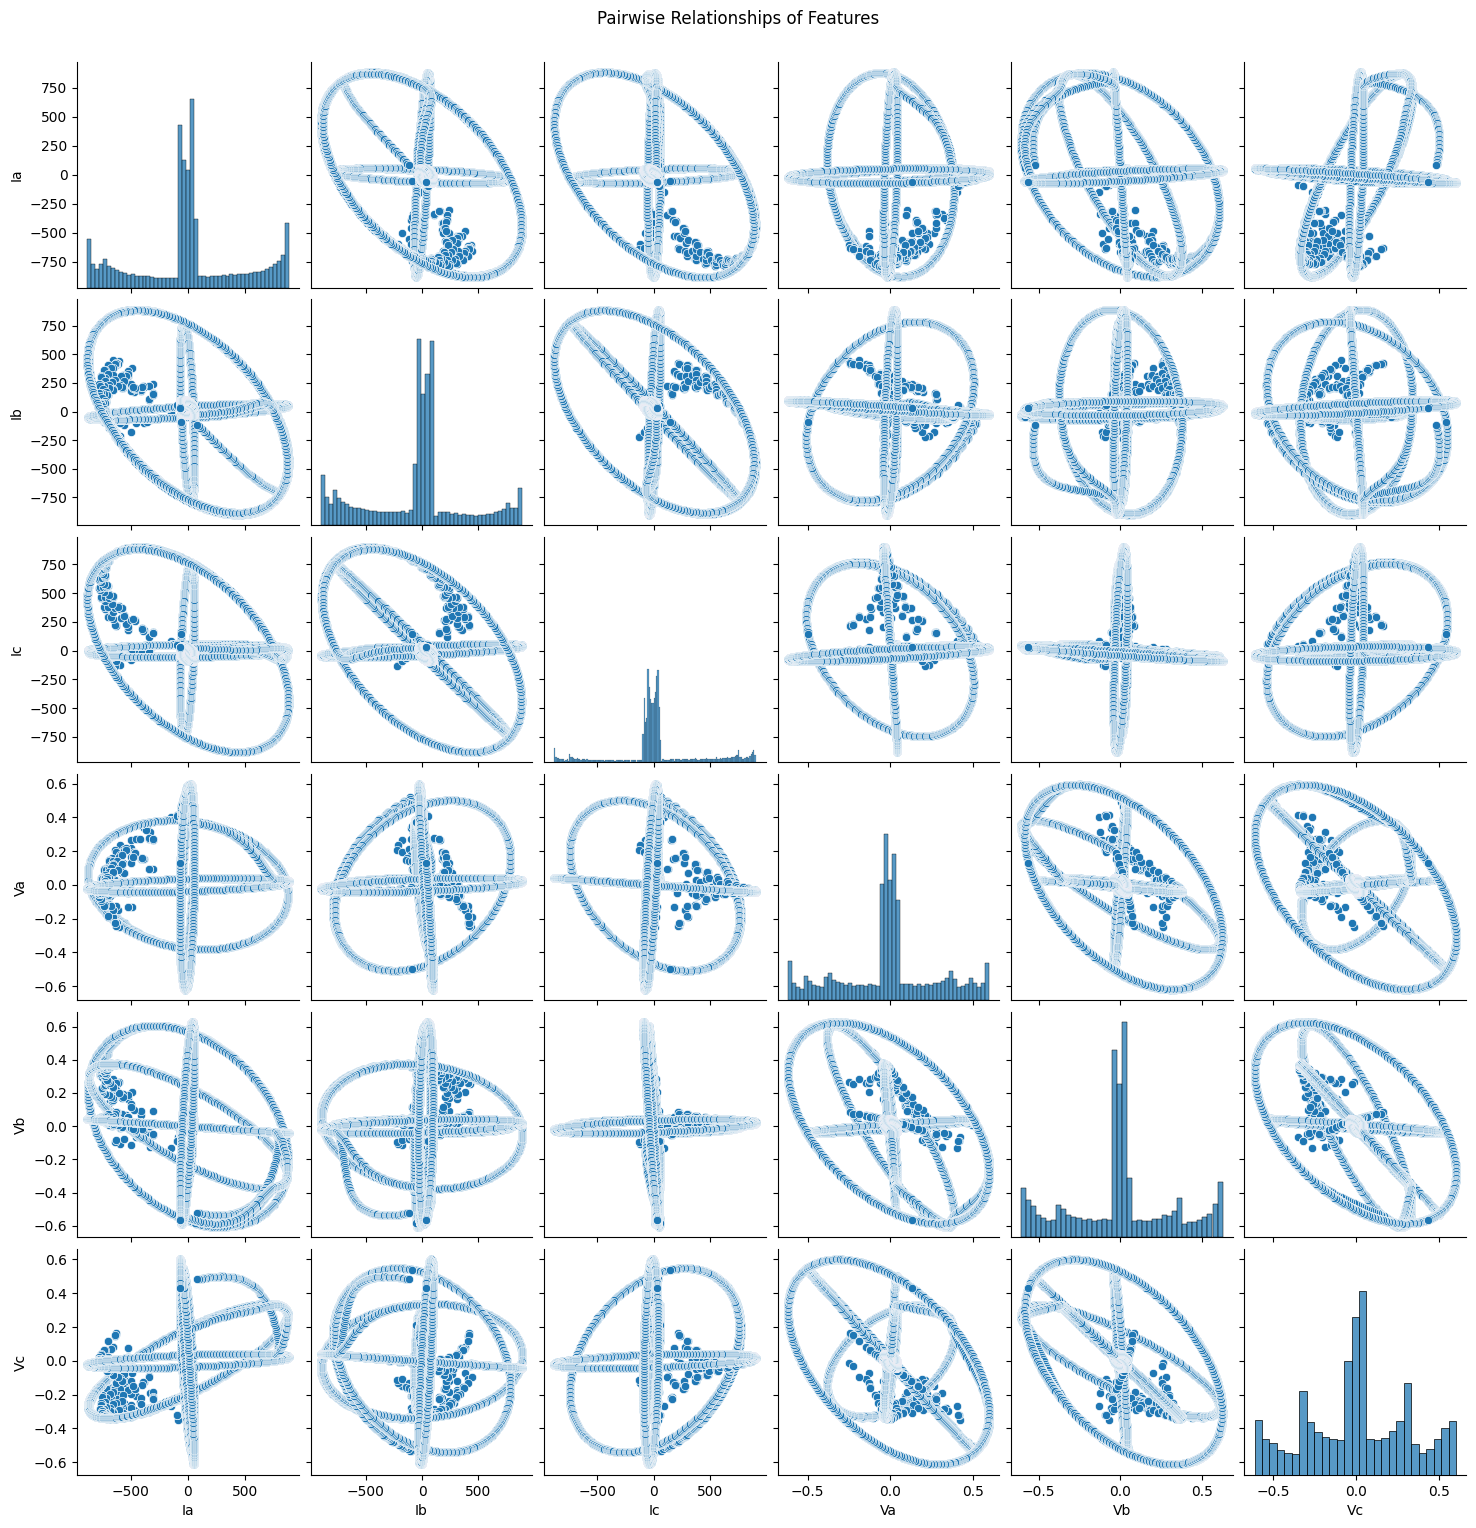

In [11]:
# Pairplot to observe pairwise relationships and distributions
sns.pairplot(data[features])
plt.suptitle('Pairwise Relationships of Features', y=1.02)
plt.show()

 # 4 Model Training & Evaluation

In [12]:
# Normalization (using Min-Max Scaling as an example)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data[features])

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform the 'Fault_Type' to integer labels
y_encoded = label_encoder.fit_transform(data['Fault_Type'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6288, 6), (1573, 6), (6288,), (1573,))

In [13]:
# Define a dictionary to store the cross-validation metrics of the algorithms
cv_metrics = {'Model': [], 'Accuracy': []}
test_metrics = {'Model': [], 'Accuracy': []}

# Define a function to train and evaluate each algorithm
def train_and_evaluate_model(model, model_name, X_train, y_train):
    # Define the scoring metrics for multi-class classification
    scoring = {
        'accuracy': make_scorer(accuracy_score),

    }

    # Perform cross-validation using StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring)
    
    # Store the cross-validation metrics
    cv_metrics['Model'].append(model_name)
    cv_metrics['Accuracy'].append(scores['test_accuracy'].mean())
    print(f"{model_name}: Cross-validation metrics calculated")
    
    # Fit the model on the entire training set
    model.fit(X_train, y_train)
    return model

# Define a function to evaluate the model on the test set and store the metrics
def evaluate_on_test_set(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    test_metrics['Model'].append(model_name)
    test_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    print(f"{model_name}: Test metrics calculated")

# Train and evaluate each algorithm
models = [
    (LogisticRegression(random_state=42, max_iter=1000), "Logistic Regression"),
    (SVC(random_state=42), "Support Vector Machines"),
    (KNeighborsClassifier(), "K-Nearest Neighbors"),
    (DecisionTreeClassifier(random_state=42), "Decision Trees"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (GradientBoostingClassifier(random_state=42), "Gradient Boosting"),
    (MLPClassifier(random_state=42, max_iter=1000), "Neural Networks"),
    (GaussianNB(), "Naive Bayes"),
    (AdaBoostClassifier(random_state=42), "AdaBoost"),
    (XGBClassifier(random_state=42), "XGBoost"),
    (LGBMClassifier(random_state=42), "LightGBM"),
    (CatBoostClassifier(random_state=42, verbose=0), "CatBoost")
]

# Train and evaluate each model
for model, model_name in models:
    fitted_model = train_and_evaluate_model(model, model_name, X_train, y_train)
    evaluate_on_test_set(fitted_model, model_name, X_test, y_test)

# Convert the dictionary of cross-validation metrics to a DataFrame
import pandas as pd
cv_metrics_df = pd.DataFrame(cv_metrics)
test_metrics_df = pd.DataFrame(test_metrics)
print("\nCross-validation Metrics:")
print(cv_metrics_df)
print("\nTest Metrics:")
print(test_metrics_df)


Logistic Regression: Cross-validation metrics calculated
Logistic Regression: Test metrics calculated
Support Vector Machines: Cross-validation metrics calculated
Support Vector Machines: Test metrics calculated
K-Nearest Neighbors: Cross-validation metrics calculated
K-Nearest Neighbors: Test metrics calculated
Decision Trees: Cross-validation metrics calculated
Decision Trees: Test metrics calculated
Random Forest: Cross-validation metrics calculated
Random Forest: Test metrics calculated
Gradient Boosting: Cross-validation metrics calculated
Gradient Boosting: Test metrics calculated
Neural Networks: Cross-validation metrics calculated
Neural Networks: Test metrics calculated
Naive Bayes: Cross-validation metrics calculated
Naive Bayes: Test metrics calculated
AdaBoost: Cross-validation metrics calculated
AdaBoost: Test metrics calculated
XGBoost: Cross-validation metrics calculated
XGBoost: Test metrics calculated
LightGBM: Cross-validation metrics calculated
LightGBM: Test metrics

* **Consistency with Cross-validation:** Most models maintain a similar ranking in performance on the test set as observed in cross-validation. This indicates good generalization of the models.
* **Top Models (Test Performance):** Decision Trees and Random Forest maintain high accuracy, with Decision Trees showing a slight edge. This suggests their robustness in handling the multiclass classification task.
* **Neural Networks Performance:** The MLPClassifier (Neural Networks) shows a respectable performance, which might be further enhanced with more tuning or a different architecture.


 # 5. Model Optimization

## 5.1 Basic Feature Engineering

In [14]:
# Define the original features
features = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']

# Feature Engineering: Creating polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(data[features])

# Creating a DataFrame with the new polynomial features
poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(features))



In [15]:
# Normalization (using Min-Max Scaling)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(poly_features_df)

# Encoding the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['Fault_Type'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Display the shapes of the new training and testing sets and the first few rows of the new feature DataFrame
X_train.shape, X_test.shape, y_train.shape, y_test.shape, poly_features_df.head()


((6288, 27),
 (1573, 27),
 (6288,),
 (1573,),
            Ia          Ib          Ic        Va        Vb        Vc  \
 0 -151.291812   -9.677452   85.800162  0.400750 -0.132935 -0.267815   
 1 -336.186183  -76.283262   18.328897  0.312732 -0.123633 -0.189099   
 2 -502.891583 -174.648023  -80.924663  0.265728 -0.114301 -0.151428   
 3 -593.941905 -217.703359 -124.891924  0.235511 -0.104940 -0.130570   
 4 -643.663617 -224.159427 -132.282815  0.209537 -0.095554 -0.113983   
 
             Ia^2          Ia Ib         Ia Ic       Ia Va  ...          Ic^2  \
 0   22889.212499    1464.119186 -12980.862053  -60.630172  ...   7361.667844   
 1  113021.149371   25645.378631  -6161.921773 -105.136155  ...    335.948450   
 2  252899.944252   87829.020905  40696.332111 -133.632598  ...   6548.801156   
 3  352766.986396  129303.147985  74178.547188 -139.879576  ...  15597.992655   
 4  414302.852236  144283.267892  85145.635467 -134.871266  ...  17498.743250   
 
        Ic Va      Ic Vb      Ic

In [16]:
features_list = list(poly_features_df.columns)


In [17]:
cv_metrics = {'Model': [], 'Accuracy': []}
test_metrics = {'Model': [], 'Accuracy': []}

# Train and evaluate each algorithm
models = [

    (DecisionTreeClassifier(random_state=42), "Decision Trees"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
]

# Train and evaluate each model
for model, model_name in models:
    fitted_model = train_and_evaluate_model(model, model_name, X_train, y_train)
    evaluate_on_test_set(fitted_model, model_name, X_test, y_test)

# Convert the dictionary of cross-validation metrics to a DataFrame
import pandas as pd
cv_metrics_df = pd.DataFrame(cv_metrics)
test_metrics_df = pd.DataFrame(test_metrics)
print("\nCross-validation Metrics:")
print(cv_metrics_df)
print("\nTest Metrics:")
print(test_metrics_df)


Decision Trees: Cross-validation metrics calculated
Decision Trees: Test metrics calculated
Random Forest: Cross-validation metrics calculated
Random Forest: Test metrics calculated

Cross-validation Metrics:
            Model  Accuracy
0  Decision Trees  0.870707
1   Random Forest  0.860210

Test Metrics:
            Model  Accuracy
0  Decision Trees  0.892562
1   Random Forest  0.883026


## 5.2 Class Imbalance Handling

In [18]:
# Create the SMOTE object
smote = SMOTE(random_state=42)

#Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
 
cv_metrics = {'Model': [], 'Accuracy': []}
test_metrics = {'Model': [], 'Accuracy': []}

# Dictionary to store trained models
trained_models = {}

# Train and evaluate each algorithm
models = [

    (DecisionTreeClassifier(random_state=42), "Decision Trees"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
]

# Train and evaluate each model
for model, model_name in models:
    fitted_model = train_and_evaluate_model(model, model_name, X_train_smote, y_train_smote)
    evaluate_on_test_set(fitted_model, model_name, X_test, y_test)
    
    # Save the trained model using joblib
    model_filename = f"{model_name.lower().replace(' ', '_')}_model.pkl"
    joblib.dump(fitted_model, model_filename)
    
    # Store the trained model in the dictionary
    trained_models[model_name] = fitted_model

# Convert the dictionary of cross-validation metrics to a DataFrame
import pandas as pd
cv_metrics_df = pd.DataFrame(cv_metrics)
test_metrics_df = pd.DataFrame(test_metrics)
print("\nCross-validation Metrics:")
print(cv_metrics_df)
print("\nTest Metrics:")
print(test_metrics_df)


Decision Trees: Cross-validation metrics calculated
Decision Trees: Test metrics calculated
Random Forest: Cross-validation metrics calculated
Random Forest: Test metrics calculated

Cross-validation Metrics:
            Model  Accuracy
0  Decision Trees  0.892970
1   Random Forest  0.893939

Test Metrics:
            Model  Accuracy
0  Decision Trees  0.898919
1   Random Forest  0.883026


In [19]:
X_train_smote.shape, y_train_smote.shape, y_train.shape, y_test.shape

((11352, 27), (11352,), (6288,), (1573,))

## 5.3 Hyper Parameter optimization using GridSearchCV for Decision Trees and Random Forest

In [20]:
# Create the pipeline with SMOTE and the classifier
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define the parameter grid for Decision Trees
dt_param_grid = {
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Perform grid search
dt_grid_search = GridSearchCV(pipeline, dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
dt_grid_search.fit(X_train, y_train)

# Extract the best parameters and the best score for Decision Trees
dt_best_params = dt_grid_search.best_params_
dt_best_score = dt_grid_search.best_score_

# Output the best parameters and score for Decision Trees
print('Best parameters for Decision Trees:', dt_best_params)
print('Best score for Decision Trees:', dt_best_score)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Decision Trees: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best score for Decision Trees: 0.872614029163236


## 5.4 Deep Learning Model

In [21]:

# Set random seed
tf.random.set_seed(42)
# Defining neural network model
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(6, activation='softmax')
    ])
    return model

# Initialize Cross-Validation Splitter
num_folds = 5  # You can choose the number of folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize Callbacks
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,           # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore best model weights
)

# Learning rate scheduling
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by 20% when validation loss plateaus
    patience=5,  # Number of epochs with no improvement before reducing LR
    min_lr=1e-7  # Minimum learning rate
)

# Perform Cross-Validation
all_fold_scores = []

for fold, (train_idx, val_idx) in enumerate(stratified_kfold.split(X_scaled, y_encoded)):
    print(f'Fold {fold + 1}/{num_folds}')
    
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y_encoded[train_idx], y_encoded[val_idx]
    
    # Create and compile the model
    model = create_model()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',  # Multiclass classification
                  metrics=['accuracy'])
    
    # Train the model with callbacks
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=100, batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        verbose=0,
        callbacks=[early_stopping_callback, 
                   lr_scheduler
                  ]
    )
    
    # Evaluate the model on this fold's test data
    fold_test_loss, fold_test_accuracy = model.evaluate(X_test, y_test)
    all_fold_scores.append(fold_test_accuracy)
    
    # You can also plot training history for each fold if needed

# Calculate and print the cross-validation accuracy
mean_cv_accuracy = sum(all_fold_scores) / num_folds
print(f'Mean Cross-Validation Accuracy: {mean_cv_accuracy * 100:.2f}%')


Fold 1/5
50/50 [==============================] - 0s 2ms/step - loss: 0.2151 - accuracy: 0.8684
Fold 2/5
50/50 [==============================] - 0s 2ms/step - loss: 0.2112 - accuracy: 0.8697
Fold 3/5
50/50 [==============================] - 0s 2ms/step - loss: 0.2153 - accuracy: 0.8538
Fold 4/5
50/50 [==============================] - 0s 2ms/step - loss: 0.2112 - accuracy: 0.8563
Fold 5/5
50/50 [==============================] - 0s 2ms/step - loss: 0.2200 - accuracy: 0.8627
Mean Cross-Validation Accuracy: 86.22%


In [22]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


50/50 [==============================] - 0s 2ms/step - loss: 0.2200 - accuracy: 0.8627
Test accuracy: 86.27%


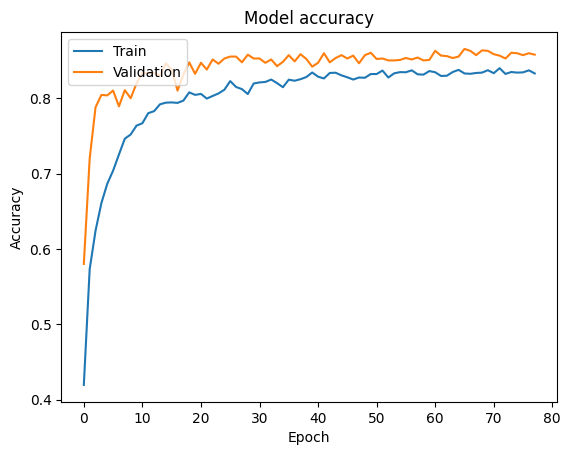

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [24]:
joblib.dump(model, 'DL_model.pkl')

['DL_model.pkl']

# 6. Analysing Best Performing Models So Far

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming you have your best models saved in the 'trained_models' dictionary
best_models = {
#    "Deep Learning": joblib.load('/kaggle/working/DL_model.pkl'),  # Replace with your loaded deep learning model
    "Decision Trees": joblib.load('/kaggle/working/decision_trees_model.pkl'),  # Replace with your loaded decision tree model
    "Random Forest": joblib.load('/kaggle/working/random_forest_model.pkl'),  # Replace with your loaded random forest model
}

# Function to evaluate and analyze model performance
def evaluate_and_analyze(model, model_name, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=class_labels)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Performance Metrics for {model_name}:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", cm)
    

# List of class labels (assuming you have them)
class_labels = ["Line A Line B to Ground Fault", "Line-to-Line AB", "Line-to-Line with Ground BC", "No Fault", "Three-Phase", "Three-Phase with Ground"]

# Evaluate and analyze each of the best models
for model_name, model in best_models.items():
    evaluate_and_analyze(model, model_name, X_test, y_test)

Performance Metrics for Decision Trees:
Accuracy: 89.89%
Classification Report:
                                precision    recall  f1-score   support

Line A Line B to Ground Fault       1.00      1.00      1.00       227
              Line-to-Line AB       1.00      1.00      1.00       226
  Line-to-Line with Ground BC       1.00      1.00      1.00       201
                     No Fault       1.00      1.00      1.00       473
                  Three-Phase       0.63      0.66      0.65       219
      Three-Phase with Ground       0.66      0.63      0.65       227

                     accuracy                           0.90      1573
                    macro avg       0.88      0.88      0.88      1573
                 weighted avg       0.90      0.90      0.90      1573

Confusion Matrix:
 [[226   1   0   0   0   0]
 [  0 226   0   0   0   0]
 [  0   0 201   0   0   0]
 [  0   0   0 473   0   0]
 [  0   0   0   0 144  75]
 [  0   0   0   0  83 144]]
Performance Metrics for 

**Decision Trees Model**
* Accuracy: 89.89%
* Strengths: Excellent performance in identifying the 'No Fault', 'Line A Line B to Ground Fault', 'Line-to-Line AB', and 'Line-to-Line with Ground BC' categories, with perfect precision and recall in these classes.
* Weaknesses: Struggles with the 'Three-Phase' and 'Three-Phase with Ground' categories, showing lower precision and recall.

**Random Forest Model**
* Accuracy: 88.30%
* Strengths: Similar to the Decision Tree model in strengths, with perfect performance in the first four categories.
* Weaknesses: Still shows some difficulty in accurately classifying the 'Three-Phase' and 'Three-Phase with Ground' categories.

Both models struggle with the 'Three-Phase' and 'Three-Phase with Ground' categories. This suggests these classes are more challenging to distinguish, possibly due to overlapping features or less distinct patterns in the data.The Decision Trees model slightly outperforms the others in terms of overall accuracy and shows a balanced performance across all categories.

# 7. Using domain knowledge to further improve the model

## 7.1 Analysing feature distribution for 'Three-Phase fault' and 'Three-Phase with Ground fault'

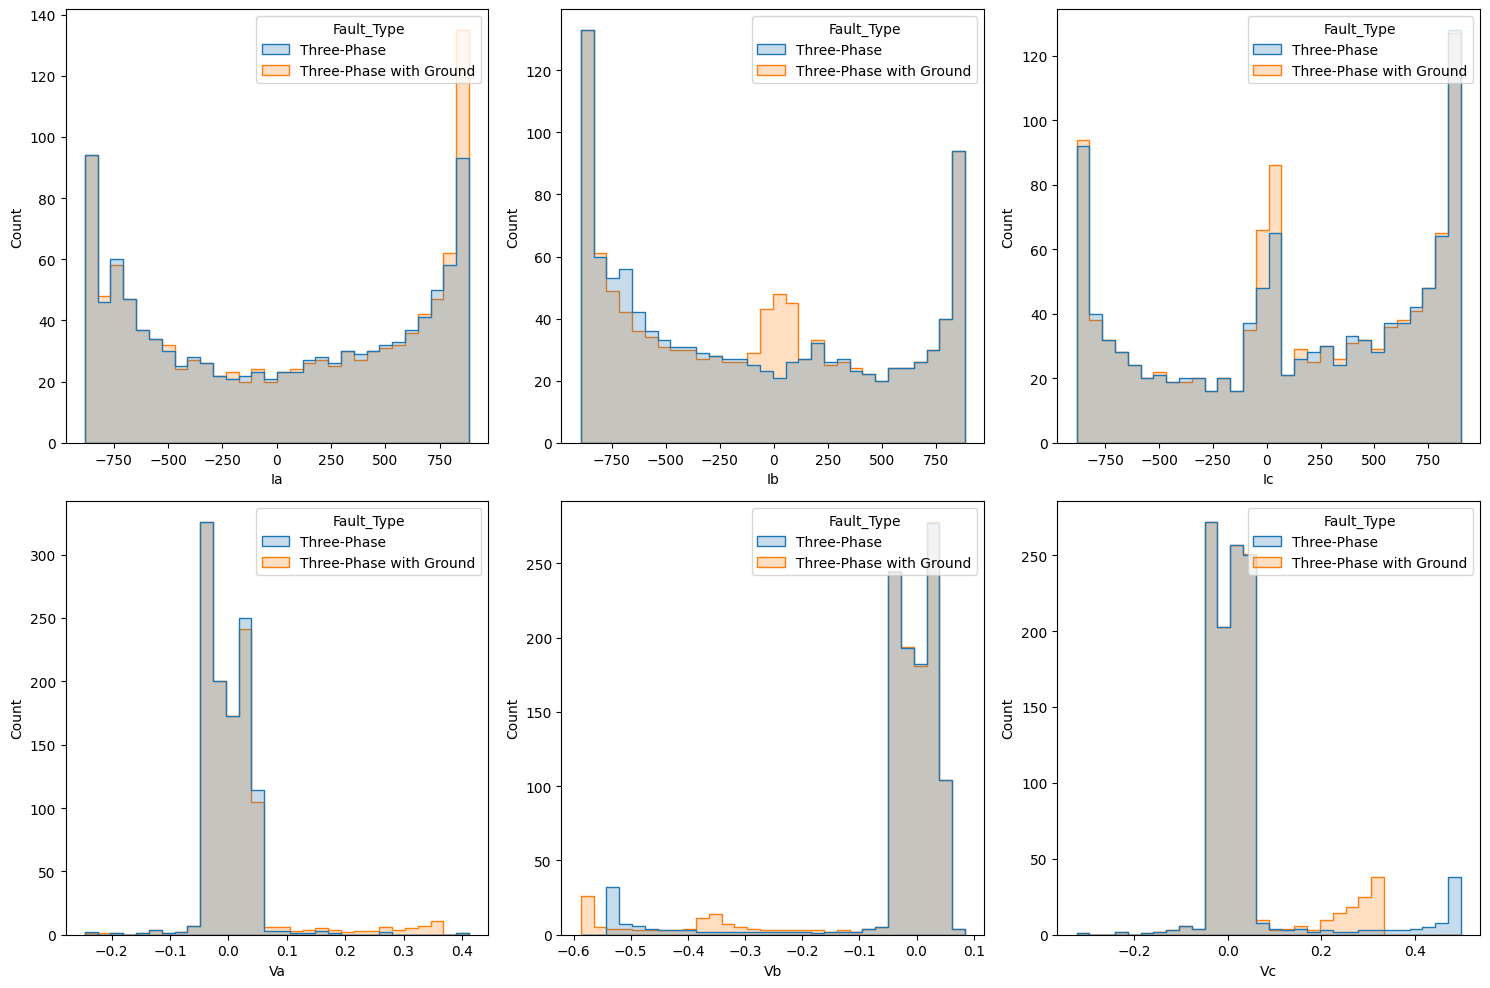

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for only 'Three-Phase Fault' and 'Three-Phase with Ground Fault'
filtered_data = data[data['Fault_Type'].isin(['Three-Phase', 'Three-Phase with Ground'])]

# Features to be plotted
features = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']

# Plotting histograms for each feature by the two fault types
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=filtered_data, x=feature, hue='Fault_Type', element='step', bins=30)
    #plt.title(f'Distribution of {feature} for Three-Phase Faults')
plt.tight_layout()
plt.show()

The histograms for 'Three-Phase Fault' and 'Three-Phase with Ground Fault' show some similarities in the distribution of current and voltage features, which can be indicative of how these two fault types may present comparable electrical characteristics in certain aspects:

1. **Overlap in Distributions:** Both fault types show overlap in the distributions of currents (Ia, Ib, Ic) and voltages (Va, Vb, Vc), suggesting that both fault types can exhibit similar magnitudes of current and voltage during a fault event.

2. **Tendency Near Zero:** The voltage features for both fault types have a central tendency near zero, which is typical in fault conditions as the voltage levels drop due to the short-circuit effect.

3. **Current Features Spread:** The spread of the current features (Ia, Ib, Ic) also appears somewhat similar for both fault types, indicating that the magnitude of the fault current does not drastically change between a three-phase fault and a three-phase fault with ground. This could be due to the similar nature of short-circuit conditions in both cases, albeit with the ground adding an additional path in one scenario.

4. **Symmetry in Current:** There is a symmetry observed in the current distributions for both fault types. This symmetry could reflect the nature of three-phase systems, where faults can lead to symmetrical increases in current across all three phases, though to varying extents.

5. **Behavior Under Fault Conditions:** The similarities in these distributions reflect the fact that under fault conditions, especially severe ones like three-phase faults, the system's normal operating conditions are significantly disrupted, leading to reduced voltage and increased current, regardless of the presence of ground.

6. **Statistical Characteristics:** Both types of faults likely share some statistical characteristics, such as mean, variance, and possibly skewness and kurtosis, which indicates that without ground, the system's responses to these faults are inherently similar.

7. **Physical Phenomena:** The physical phenomena driving the electrical responses are related—both involve all three phases, which can lead to system-wide effects that manifest in the electrical parameters measured.

These similarities pose a challenge for machine learning models to differentiate between the two fault types solely based on current and voltage magnitudes. It suggests the need for more sophisticated features that can capture subtle differences, perhaps related to phase angles, harmonics, or transient behaviors that are not as easily discernible in simple magnitude-based measurements.

## 7.2 Advanced Feature Engineering

In [27]:
# Adding new features based on domain knowledge

# Zero Sequence Components for Current and Voltage
poly_features_df['ZeroSeqCurrent'] = (poly_features_df['Ia'] + poly_features_df['Ib'] + poly_features_df['Ic']) / 3
poly_features_df['ZeroSeqVoltage'] = (poly_features_df['Va'] + poly_features_df['Vb'] + poly_features_df['Vc']) / 3

# Phase Angle Differences (approximated by product of current and voltage)
poly_features_df['PhaseAngleDiffI'] = poly_features_df['Ia'] * poly_features_df['Ib'] * poly_features_df['Ic']
poly_features_df['PhaseAngleDiffV'] = poly_features_df['Va'] * poly_features_df['Vb'] * poly_features_df['Vc']

# Total Harmonic Distortion (THD) - Approximation
poly_features_df['THD_Ia'] = np.sqrt(poly_features_df['Ia^2'] - poly_features_df['Ia']**2) / poly_features_df['Ia']
poly_features_df['THD_Ib'] = np.sqrt(poly_features_df['Ib^2'] - poly_features_df['Ib']**2) / poly_features_df['Ib']
poly_features_df['THD_Ic'] = np.sqrt(poly_features_df['Ic^2'] - poly_features_df['Ic']**2) / poly_features_df['Ic']

# Voltage and Current Ratios
poly_features_df['V_I_Ratio_A'] = poly_features_df['Va'] / poly_features_df['Ia']
poly_features_df['V_I_Ratio_B'] = poly_features_df['Vb'] / poly_features_df['Ib']
poly_features_df['V_I_Ratio_C'] = poly_features_df['Vc'] / poly_features_df['Ic']


In [28]:
features_list = list(poly_features_df.columns)

In [29]:
# Normalization (using Min-Max Scaling)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(poly_features_df)

# Encoding the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['Fault_Type'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Display the shapes of the new training and testing sets and the first few rows of the new feature DataFrame
X_train.shape, X_test.shape, y_train.shape, y_test.shape
poly_features_df.head()

,Ia,Ib,Ic,Va,Vb,Vc,Ia^2,Ia Ib,Ia Ic,Ia Va,...,ZeroSeqCurrent,ZeroSeqVoltage,PhaseAngleDiffI,PhaseAngleDiffV,THD_Ia,THD_Ib,THD_Ic,V_I_Ratio_A,V_I_Ratio_B,V_I_Ratio_C
0,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,22889.212499,1464.119186,-12980.862053,-60.630172,...,-25.056367,3.333333e-10,1.256217e+05,0.014267,-0.0,-0.0,0.0,-0.002649,0.013737,-0.003121
1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,113021.149371,25645.378631,-6161.921773,-105.136155,...,-131.380183,-3.333333e-10,4.700515e+05,0.007311,-0.0,-0.0,0.0,-0.000930,0.001621,-0.010317
2,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,252899.944252,87829.020905,40696.332111,-133.632598,...,-252.821423,9.251859e-18,-7.107534e+06,0.004599,-0.0,-0.0,-0.0,-0.000528,0.000654,0.001871
3,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,352766.986396,129303.147985,74178.547188,-139.879576,...,-312.179063,0.000000e+00,-1.614892e+07,0.003227,-0.0,-0.0,-0.0,-0.000397,0.000482,0.001045
4,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,414302.852236,144283.267892,85145.635467,-134.871266,...,-333.368620,0.000000e+00,-1.908620e+07,0.002282,-0.0,-0.0,-0.0,-0.000326,0.000426,0.000862


In [30]:
# Define a dictionary to store the cross-validation metrics of the algorithms
cv_metrics = {'Model': [], 'Accuracy': []}
test_metrics = {'Model': [], 'Accuracy': []}

# Define a function to train and evaluate each algorithm
def train_and_evaluate_model(model, model_name, X_train, y_train):
    # Define the scoring metrics for multi-class classification
    scoring = {
        'accuracy': make_scorer(accuracy_score),

    }

    # Perform cross-validation using StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring)
    
    # Store the cross-validation metrics
    cv_metrics['Model'].append(model_name)
    cv_metrics['Accuracy'].append(scores['test_accuracy'].mean())
    print(f"{model_name}: Cross-validation metrics calculated")
    
    # Fit the model on the entire training set
    model.fit(X_train, y_train)
    
    # Save the fitted model to a pickle file
    model_filename = f'{model_name.replace(" ", "_")}_model.pkl'
    joblib.dump(model, model_filename)
    print(f"{model_name}: Model saved as {model_filename}")
    
    return model

# Define a function to evaluate the model on the test set and store the metrics
def evaluate_on_test_set(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    test_metrics['Model'].append(model_name)
    test_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    print(f"{model_name}: Test metrics calculated")

# Train and evaluate each algorithm
models = [
    (LogisticRegression(random_state=42, max_iter=1000), "Logistic Regression"),
    (SVC(random_state=42), "Support Vector Machines"),
    (KNeighborsClassifier(), "K-Nearest Neighbors"),
    (DecisionTreeClassifier(random_state=42), "Decision Trees"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (GradientBoostingClassifier(random_state=42), "Gradient Boosting"),
    (MLPClassifier(random_state=42, max_iter=1000), "Neural Networks"),
    (GaussianNB(), "Naive Bayes"),
    (AdaBoostClassifier(random_state=42), "AdaBoost"),
    (XGBClassifier(random_state=42), "XGBoost"),
    (LGBMClassifier(random_state=42), "LightGBM"),
    (CatBoostClassifier(random_state=42, verbose=0), "CatBoost")
]

# Train and evaluate each model
for model, model_name in models:
    fitted_model = train_and_evaluate_model(model, model_name, X_train, y_train)
    evaluate_on_test_set(fitted_model, model_name, X_test, y_test)

# Convert the dictionary of cross-validation metrics to a DataFrame
import pandas as pd
cv_metrics_df = pd.DataFrame(cv_metrics)
test_metrics_df = pd.DataFrame(test_metrics)
print("\nCross-validation Metrics:")
print(cv_metrics_df)
print("\nTest Metrics:")
print(test_metrics_df)

Logistic Regression: Cross-validation metrics calculated
Logistic Regression: Model saved as Logistic_Regression_model.pkl
Logistic Regression: Test metrics calculated
Support Vector Machines: Cross-validation metrics calculated
Support Vector Machines: Model saved as Support_Vector_Machines_model.pkl
Support Vector Machines: Test metrics calculated
K-Nearest Neighbors: Cross-validation metrics calculated
K-Nearest Neighbors: Model saved as K-Nearest_Neighbors_model.pkl
K-Nearest Neighbors: Test metrics calculated
Decision Trees: Cross-validation metrics calculated
Decision Trees: Model saved as Decision_Trees_model.pkl
Decision Trees: Test metrics calculated
Random Forest: Cross-validation metrics calculated
Random Forest: Model saved as Random_Forest_model.pkl
Random Forest: Test metrics calculated
Gradient Boosting: Cross-validation metrics calculated
Gradient Boosting: Model saved as Gradient_Boosting_model.pkl
Gradient Boosting: Test metrics calculated
Neural Networks: Cross-valid

The results presented indicate the performance of various machine learning models on both cross-validation and test datasets. Here's an analysis:

1. High Performers: The Random Forest, XGBoost, LightGBM, and CatBoost models show remarkably high accuracy, with LightGBM and CatBoost achieving perfect accuracy on the test set. This suggests that ensemble methods, particularly those based on decision trees, are highly effective for this dataset.

2. Consistency: There is consistency between cross-validation and test metrics, which is a good indication that the models are not overfitting and are generalizing well to unseen data.

Given these results,the ensemble models, particularly LightGBM or CatBoost, would be strong candidates due to their high performance and the consistency of their results.

In [48]:
best_models = {
    "CatBoost": joblib.load('/kaggle/working/CatBoost_model.pkl'),  
    "LightGBM": joblib.load('/kaggle/working/LightGBM_model.pkl'),  
    "Random Forest": joblib.load('/kaggle/working/Random_Forest_model.pkl'),  
}

# Function to evaluate and analyze model performance
def evaluate_and_analyze(model, model_name, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=class_labels)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Performance Metrics for {model_name}:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", cm)
    

# List of class labels (assuming you have them)
class_labels = ["Line A Line B to Ground Fault", "Line-to-Line AB", "Line-to-Line with Ground BC", "No Fault", "Three-Phase", "Three-Phase with Ground"]

# Evaluate and analyze each of the best models
for model_name, model in best_models.items():
    evaluate_and_analyze(model, model_name, X_test, y_test)

Performance Metrics for CatBoost:
Accuracy: 100.00%
Classification Report:
                                precision    recall  f1-score   support

Line A Line B to Ground Fault       1.00      1.00      1.00       227
              Line-to-Line AB       1.00      1.00      1.00       226
  Line-to-Line with Ground BC       1.00      1.00      1.00       201
                     No Fault       1.00      1.00      1.00       473
                  Three-Phase       1.00      1.00      1.00       219
      Three-Phase with Ground       1.00      1.00      1.00       227

                     accuracy                           1.00      1573
                    macro avg       1.00      1.00      1.00      1573
                 weighted avg       1.00      1.00      1.00      1573

Confusion Matrix:
 [[227   0   0   0   0   0]
 [  0 226   0   0   0   0]
 [  0   0 201   0   0   0]
 [  0   0   0 473   0   0]
 [  0   0   0   0 219   0]
 [  0   0   0   0   0 227]]
Performance Metrics for Light

# 8. Model Interpretation

## 8.1 Finding Feature Importances

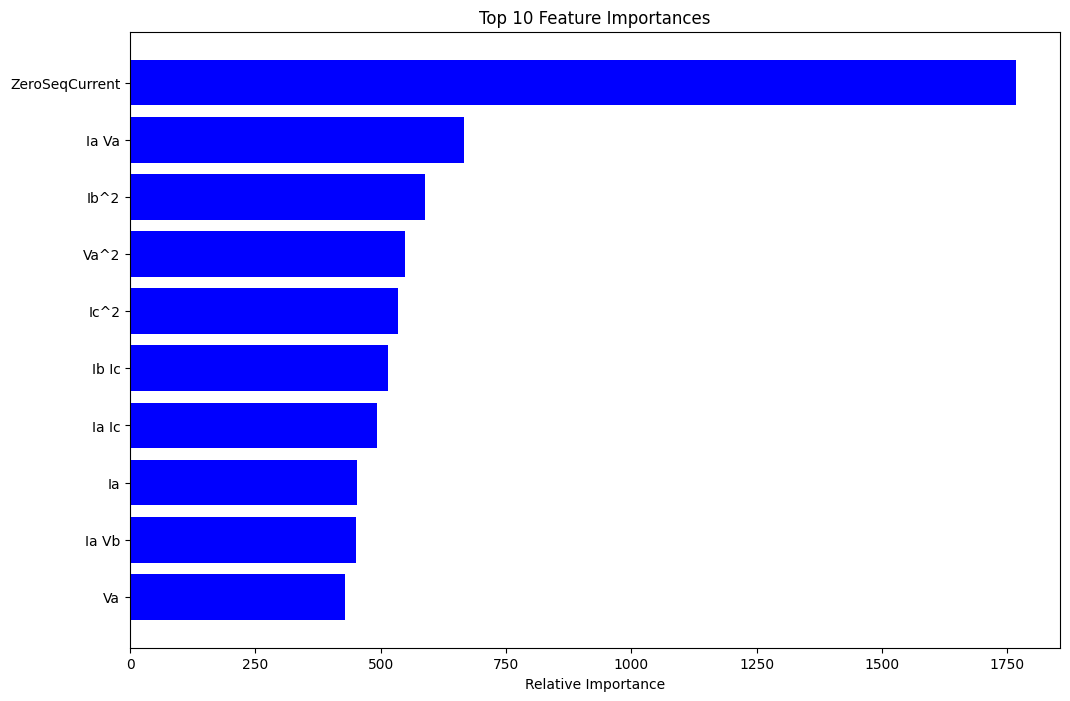

In [49]:
# Feature Importance Analysis - showing top 10 features
feature_importances = best_models['LightGBM'].feature_importances_

#feature_importances = best_models['CatBoost'].feature_importances_

indices = np.argsort(feature_importances)[-10:]  # Get indices of the top 12 features

plt.figure(figsize=(12, 8))
plt.title('Top 10 Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features_list[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

The feature 'ZeroSeqCurrent', has a significantly higher importance score compared to the others. This suggests that the zero sequence current, which is a feature engineered based on domain knowledge, has become a crucial indicator for the model's predictions, potentially differentiating between fault types effectively.

The other features listed are combinations of the original current and voltage features (Ia, Ib, Ic, Va, Vb, Vc) and their squared terms, as well as interactions between currents and voltages (like Ia Vc). These features are also contributing to the model's ability to make accurate predictions but to a lesser extent than the zero sequence current.

## 8.2 Building a less complex model with only top 5 features

CatBoost accuracy with top 5 features: 0.9987
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       227
           1       1.00      1.00      1.00       226
           2       1.00      1.00      1.00       201
           3       1.00      1.00      1.00       473
           4       1.00      1.00      1.00       219
           5       1.00      1.00      1.00       227

    accuracy                           1.00      1573
   macro avg       1.00      1.00      1.00      1573
weighted avg       1.00      1.00      1.00      1573

[[226   1   0   0   0   0]
 [  0 226   0   0   0   0]
 [  0   0 201   0   0   0]
 [  0   0   0 473   0   0]
 [  0   0   0   0 219   0]
 [  1   0   0   0   0 226]]


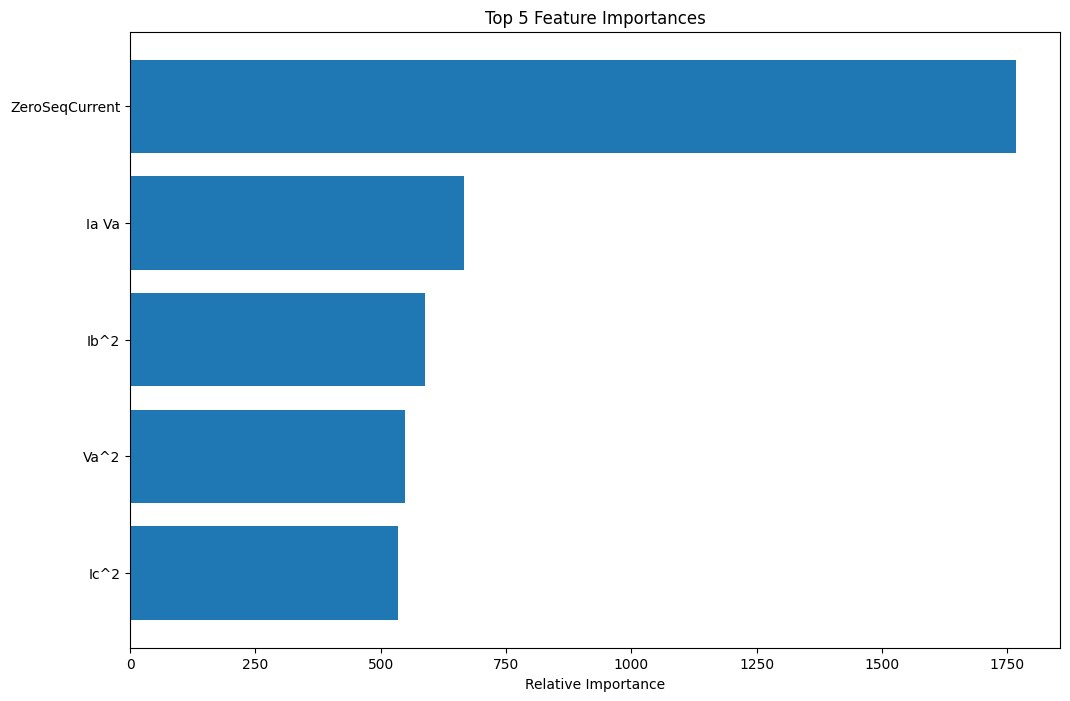

In [50]:
# Identify the top 10 features from the LightGBM model
feature_importances = best_models['LightGBM'].feature_importances_
indices = np.argsort(feature_importances)[-5:]
top_features = [features_list[i] for i in indices]

# Create a DataFrame with only the top 10 features
top_features_df = poly_features_df[top_features]

# Normalize the top features
scaler = MinMaxScaler()
X_top_scaled = scaler.fit_transform(top_features_df)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['Fault_Type'])

# Split the data into training and testing sets
X_top_train, X_top_test, y_top_train, y_top_test = train_test_split(
    X_top_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Initialize the models with only the top 10 features
models_top_features = [
    (CatBoostClassifier(random_state=42, verbose=0), 'CatBoost')
]

# Train and evaluate each model
for model, model_name in models_top_features:
    # Train the model
    model.fit(X_top_train, y_top_train)
    
    # Save the fitted model
    joblib.dump(model, f'{model_name}_top_features_model.pkl')
    
    # Predict on the test set
    y_pred = model.predict(X_top_test)
    
    # Calculate and print the accuracy
    accuracy = accuracy_score(y_top_test, y_pred)
    print(f'{model_name} accuracy with top 5 features: {accuracy:.4f}')

    # Optionally, display the classification report and confusion matrix
    print(classification_report(y_top_test, y_pred))
    print(confusion_matrix(y_top_test, y_pred))

# Plot feature importances for visualization
plt.figure(figsize=(12, 8))
plt.title('Top 5 Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), top_features)
plt.xlabel('Relative Importance')
plt.show()


The evaluation metrics shows that CatBoost model trained with the top 5 features demonstrate outstanding performance, almost reaching 100% accuracy, which is consistent with the results from using all 57 features. This indicates a few key points:
1. **Highly Predictive Features:** The top 5 features seem to hold most of the predictive power necessary for accurate classification in this dataset. This is a significant finding, as it suggests that these features capture the essential information needed to differentiate between the various fault types.
2. **Model Efficiency:** Using fewer features without compromising on accuracy can lead to more efficient models. It simplifies the model, reduces the risk of overfitting, and can improve computational efficiency.
3. **Feature Engineering Success:** The success with fewer features also indicates that your feature engineering process was highly effective. The engineered features are capturing crucial information that allows the model to perform well even with a reduced feature set.
4. **Real-world Application:** For practical applications, using a model with fewer features can be advantageous. It can reduce the data collection requirements and computational costs while maintaining high accuracy.

Given these insights, we might consider deploying the model with the top 5 features for real-world applications, especially if computational efficiency and model simplicity are priorities. 

# 8. Conclusion

This project's journey to develop a real-time electrical fault detection and classification system culminates in a robust suite of ensemble models that have far exceeded performance expectations. The Random Forest, XGBoost, LightGBM, and CatBoost algorithms, in particular, have shown stellar accuracy, validating the profound impact that machine learning can have on real-time monitoring and predictive maintenance in the electrical domain.

A key to our success was the strategic feature engineering process, which was significantly enhanced by domain-specific insights. The incorporation of sophisticated features like the zero sequence current and various interactive terms between currents and voltages was instrumental in differentiating between fault types. This is reflected in the top feature importances, which signify the model's dependency on a nuanced combination of engineered and original attributes—a testament to the intricate nature of electrical fault dynamics.

The methodical pathway we followed, from meticulous data preprocessing to the deployment of advanced algorithms, has established a strong foundation. This ensures that the system we've designed is not only theoretically sound but also primed for real-world application and integration into electrical grid infrastructures.

The project's evolution from a conceptual framework to a deployable, innovative product stands as a testament to the transformative power of machine learning in the industrial sector. It marks a significant step toward revolutionizing how we approach fault detection and maintenance, paving the way for smarter, safer, and more efficient power distribution networks.